In [ ]:
# notebooks/3.4_CNN_VGGish_Classifier.ipynb

Loading metadata and embeddings...
[SKIP] 098565: Unexpected shape ()
[SKIP] 098569: Unexpected shape ()
Loaded 7994 embeddings, missing 2
Splitting data and training classifier...
Evaluating classifier...
               precision    recall  f1-score   support

   Electronic       0.62      0.70      0.66       200
 Experimental       0.53      0.59      0.56       200
         Folk       0.70      0.73      0.72       200
      Hip-Hop       0.79      0.72      0.75       199
 Instrumental       0.64      0.66      0.65       200
International       0.75      0.69      0.72       200
          Pop       0.37      0.32      0.34       200
         Rock       0.67      0.65      0.66       200

     accuracy                           0.63      1599
    macro avg       0.63      0.63      0.63      1599
 weighted avg       0.63      0.63      0.63      1599



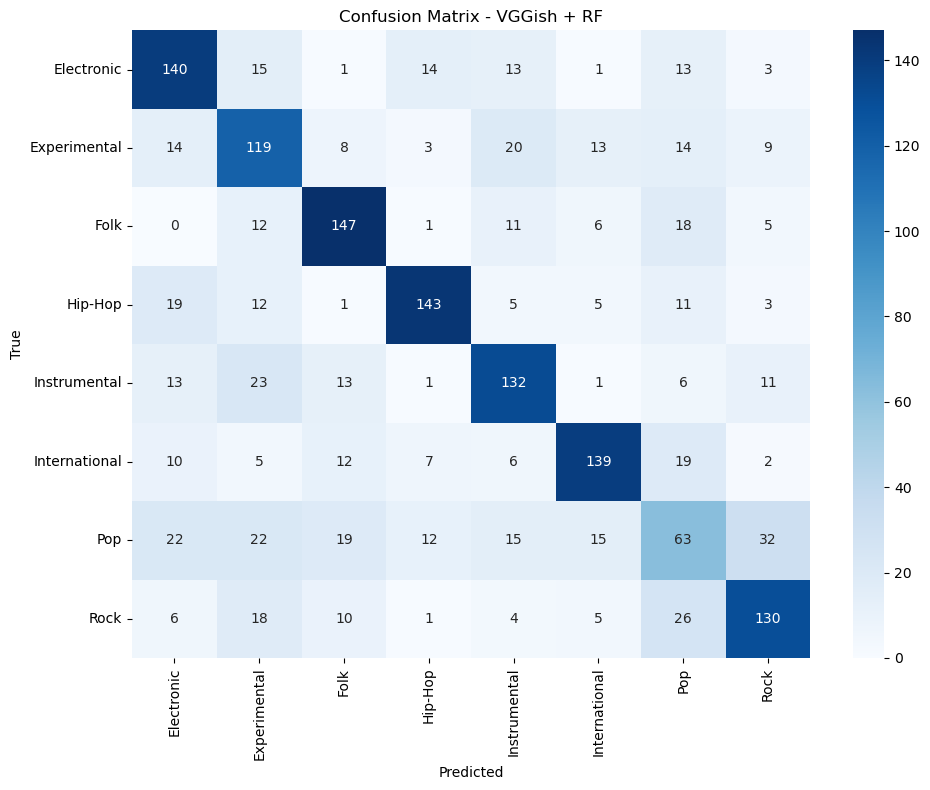

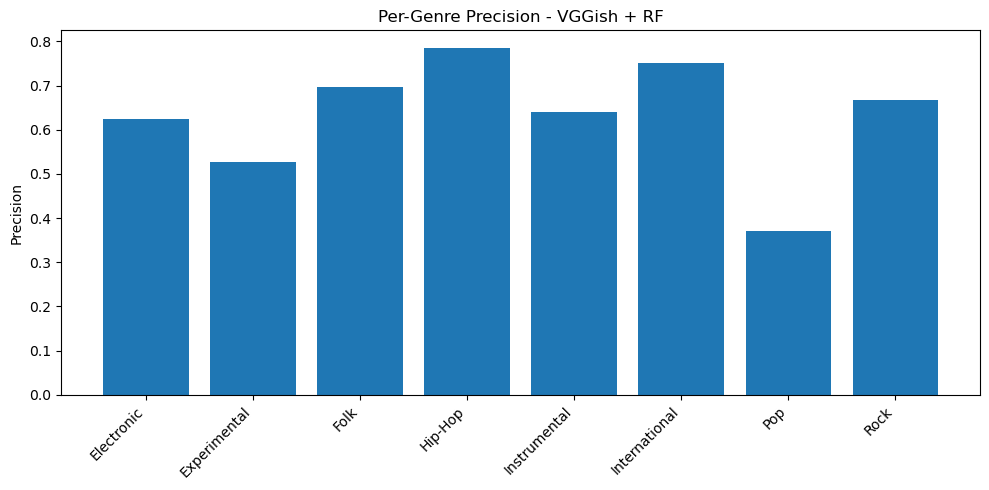

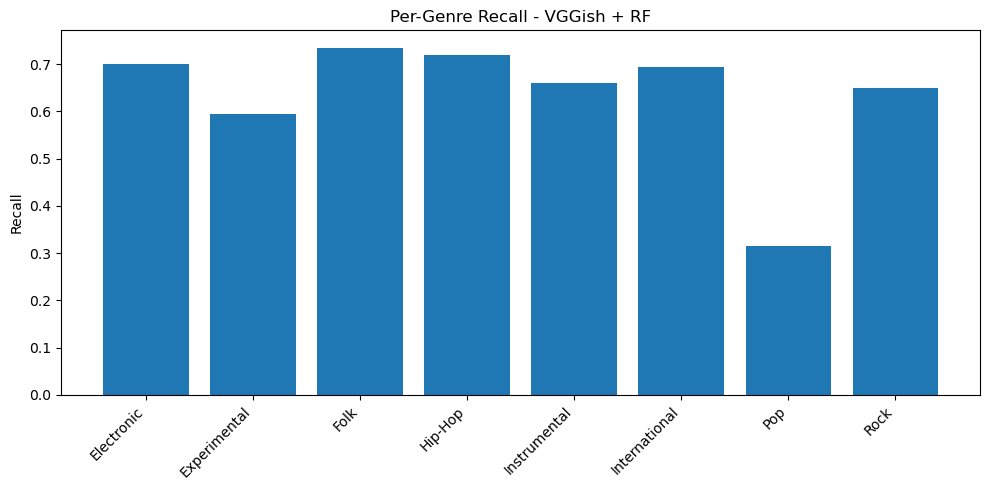

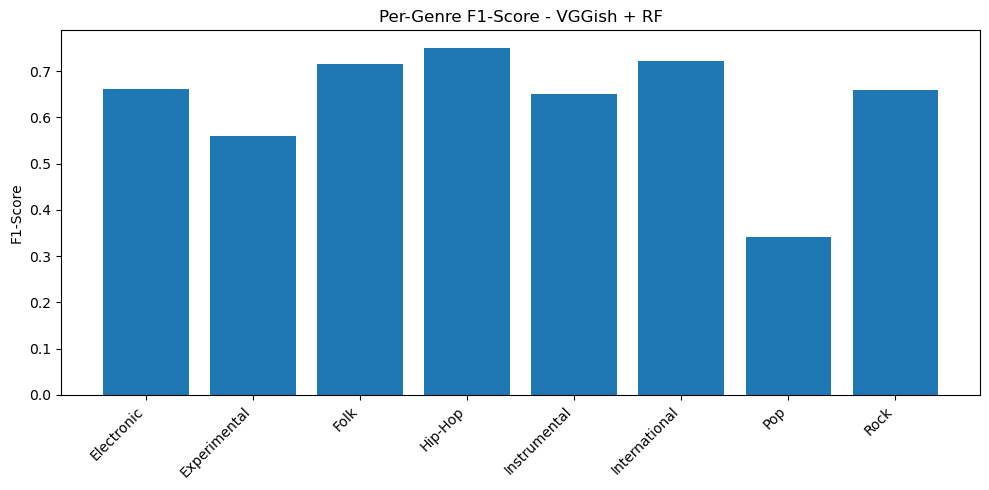

Saved trained model to ../models/vggish_rf_model.pkl


In [ ]:
import os
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

EMBEDDING_DIR = "../data/vggish_embeddings_v2"
METADATA_FILE = "../data/metadata.csv"
REPORT_DIR = "../reports/3.4_VGGish_RF"
MODEL_SAVE_PATH = "../models/vggish_rf_model.pkl"
os.makedirs(REPORT_DIR, exist_ok=True)


def load_metadata(metadata_file, embedding_dir):
    df = pd.read_csv(metadata_file)
    available_ids = {int(f.split(".")[0]) for f in os.listdir(
        embedding_dir) if f.endswith(".npy")}
    df = df[df["track_id"].isin(available_ids)]
    df['label'] = LabelEncoder().fit_transform(df['genre'])
    df['track_id_str'] = df['track_id'].apply(lambda x: f"{int(x):06d}")
    return df


def load_embeddings(df):
    X, y, missing = [], [], []
    for _, row in df.iterrows():
        track_id = row["track_id_str"]
        label = row["label"]
        path = os.path.join(EMBEDDING_DIR, f"{track_id}.npy")

        if os.path.exists(path):
            embedding = np.load(path)
            if embedding.ndim == 2:
                mean_embedding = embedding.mean(axis=0)
            elif embedding.ndim == 1:
                mean_embedding = embedding
            else:
                print(f"[SKIP] {track_id}: Unexpected shape {embedding.shape}")
                missing.append(track_id)
                continue

            X.append(mean_embedding)
            y.append(label)
        else:
            missing.append(track_id)

    return np.array(X), np.array(y), missing


def train_rf_model(X_train, y_train):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf


def evaluate_rf_model(clf, X_test, y_test, class_names):
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    with open(os.path.join(REPORT_DIR, "vggish_rf_classification_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix - VGGish + RF")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Add the text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, "vggish_rf_confusion_matrix.png"))
    plt.show()
    plt.close()

    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=range(len(class_names)), zero_division=0
    )
    for metric_name, values in zip(["Precision", "Recall", "F1-Score"], [precision, recall, f1]):
        plt.figure(figsize=(10, 5))
        plt.bar(class_names, values)
        plt.ylabel(metric_name)
        plt.title(f"Per-Genre {metric_name} - VGGish + RF")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        filename = f"vggish_rf_per_genre_{metric_name.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(REPORT_DIR, filename))
        plt.show()
        plt.close()


def main():
    print("Loading metadata and embeddings...")
    df = load_metadata(METADATA_FILE, EMBEDDING_DIR)
    class_names = LabelEncoder().fit(df["genre"]).classes_
    X, y, missing = load_embeddings(df)
    print(f"Loaded {len(X)} embeddings, missing {len(missing)}")

    print("Splitting data and training classifier...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42)
    clf = train_rf_model(X_train, y_train)

    print("Evaluating classifier...")
    evaluate_rf_model(clf, X_test, y_test, class_names)
    joblib.dump(clf, MODEL_SAVE_PATH)
    print(f"Saved trained model to {MODEL_SAVE_PATH}")


if __name__ == "__main__":
    main()